Es ist mir schleierhaft, warum das notwendig ist:

In [1]:
import os,sys
LOCAL_PATH=os.environ['HOME'] + '/.virtualenv/image_segmentation/lib/python3.11/site-packages'
if LOCAL_PATH not in sys.path:
    sys.path.insert(0,LOCAL_PATH)
sys.path

['/home/dirk/.virtualenv/image_segmentation/lib/python3.11/site-packages',
 '/usr/lib/python311.zip',
 '/usr/lib/python3.11',
 '/usr/lib/python3.11/lib-dynload',
 '',
 '/usr/lib/python3.11/site-packages']

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator


In [3]:
# SAM-Modell laden (Modell und Gewichtspfad anpassen)
model_type = "vit_h"  # Optionen: "vit_b", "vit_l", "vit_h"
checkpoint_path = "sam_vit_h_4b8939.pth"  # Lade dies von der offiziellen SAM-Repository
sam = sam_model_registry[model_type](checkpoint=checkpoint_path)

/home/dirk/.virtualenv/image_segmentation/lib/python3.11/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.lo

In [4]:
# Ergebnisse visualisieren und Masken speichern
def show_anns(image, masks):
    if len(masks) == 0:
        print("Keine Segmente gefunden!")
        return
    
    annotated_image = image.copy()
    for mask in masks:
        # Zeichne jede Maske grün und speichere sie separat
        #annotated_image[mask["segmentation"]] = [0, 255, 0]
        img = np.ones((mask["segmentation"].shape[0], mask["segmentation"].shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
            plt.imshow(np.dstack((img, mask["segmentation"]*0.5)))

        
    # Zeige die annotierte Version
    plt.figure(figsize=(10, 10))
    plt.imshow(annotated_image)
    plt.axis("off")
    plt.show()

    # Optional: Speichere das annotierte Bild
    cv2.imwrite("segmented_output.png", cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))


In [5]:
# Bounding-Boxen zeichnen
def draw_bounding_boxes(image, masks):
    boxed_image = image.copy()
    for mask in masks:
        # Berechne die Bounding-Box der Maske
        coords = np.where(mask["segmentation"])
        #y_min, y_max = np.min(coords[0]), np.max(coords[0])
        #x_min, x_max = np.min(coords[1]), np.max(coords[1])
        x_min, y_min, x_max, y_max = mask['bbox']
        x_max += x_min
        y_max += y_min
        
        # Zeichne die Bounding-Box
        cv2.rectangle(boxed_image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)  # Blau für Boxen
    
    plt.figure(figsize=(10, 10))
    plt.imshow(boxed_image)
    plt.axis("off")
    plt.show()
    
    # Optional: Speichere das Bild mit Bounding-Boxen
    cv2.imwrite("segmented_with_boxes.png", cv2.cvtColor(boxed_image, cv2.COLOR_RGB2BGR))

In [6]:
# Automatic Mask Generator mit erweiterten Parametern initialisieren
mask_generator = SamAutomaticMaskGenerator(
    sam,
    #points_per_side=32,  # Erhöht die Maskenauflösung
    #pred_iou_thresh=0.9,  # Höhere Genauigkeit der Masken
    #stability_score_thresh=0.9,  # Nur stabile Masken verwenden
    #min_mask_region_area=1000,  # Minimale Maskengröße (in Pixeln)
)


In [7]:
# Entweder Bildpfad laden
#image_path = "../sisax-hackathon/assets/chineese-pages.jpg"
#image = cv2.imread(image_path)

# Oder URL laden
import requests,PIL,urllib
from io import BytesIO

response = requests.get('https://content.staatsbibliothek-berlin.de/dms/PPN3376911983/800/0/00000003.tif?original=true')
image = cv2.cvtColor(np.array(PIL.Image.open(BytesIO(response.content))), cv2.COLOR_BGR2RGB)

In [8]:
# Segmentierung durchführen
masks = mask_generator.generate(image)

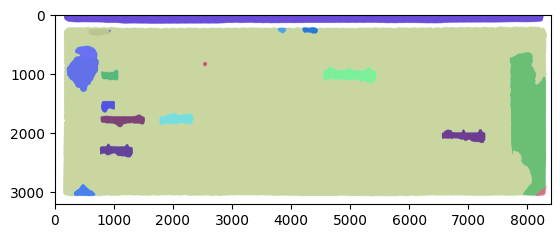

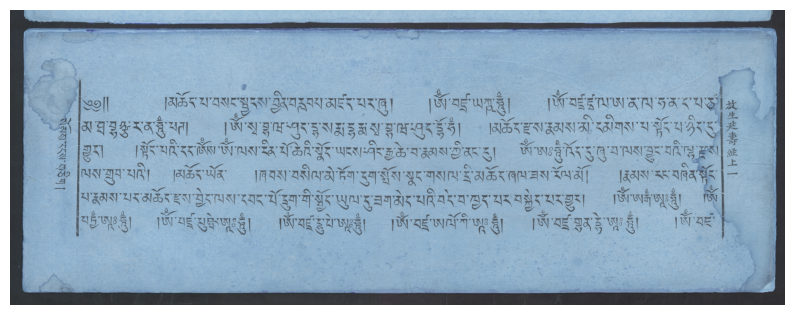

In [9]:
# Anzeigen der Segmente
show_anns(image, masks)

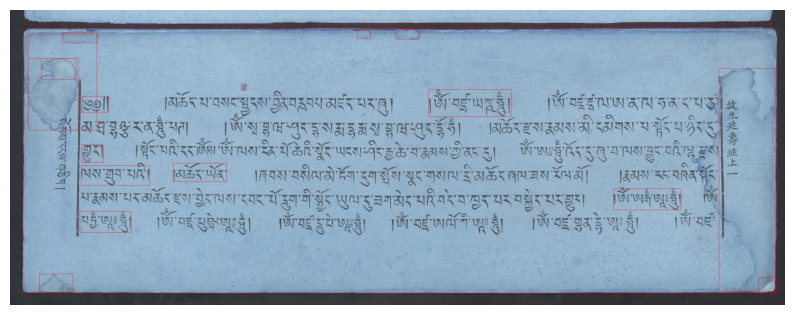

In [10]:
# Bounding-Boxen zeichnen
draw_bounding_boxes(image, masks)